<a href="https://colab.research.google.com/github/micah-shull/RAG-LangChain/blob/main/LC_013_RAG_EconRAG_URLTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ✅ Changes to Implement

### 🔧 1. **Increase Retriever Depth**

* Change `k = 2` → `k = 4`
  → To ensure retrieval of deeper content, especially pricing and onboarding details near the end of docs.

---

### ✍️ 2. **Update Source Documents**

* **Moved important content up** (e.g., pricing, free assessment)
* **Renamed vague headers** (e.g., `# Summary` → `# Cashflow4cast reduces forecasting errors by`)
* **Added new structured section** for data privacy and onboarding steps

---

### 📄 3. **Enhanced Prompt with Few-Shot Examples**

* Added 6 tailored examples:

  * What does Cashflow4cast do?
  * How does it work?
  * What does it cost?
  * How often are forecasts updated?
  * What economic indicators do you use?
  * How do you test if my data is a good fit?

---

### 🧠 4. **Improve Model Guidance**

* Few-shot examples now:

  * Emphasize clarity, tone, structure
  * Include sensitive topics like **data privacy** and **trust-building**
  * Highlight **full pricing tiers** and **onboarding steps**

---

These changes are designed to improve **retrieval coverage, response completeness, and customer trust signals** in the chatbot response.




## Pip Intsall


In [1]:
!pip install --upgrade --quiet \
    langchain \
    langchain-huggingface \
    langchain-openai \
    langchain-community \
    chromadb \
    python-dotenv \
    transformers \
    accelerate \
    sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 105.5 MB/s eta 0

## Load Libs

In [2]:
# 🌿 Environment setup
import os                                 # File paths and OS interaction
from dotenv import load_dotenv            # Load environment variables from .env file
import langchain; print(langchain.__version__)  # Check LangChain version

# 📄 Document loading and preprocessing
from langchain_core.documents import Document                   # Base document type
from langchain_community.document_loaders import TextLoader     # Loads plain text files
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Splits long docs into smaller chunks

# 🔢 Embeddings + vector storage
from langchain_huggingface import HuggingFaceEmbeddings         # HuggingFace embedding model
from langchain.vectorstores import Chroma                       # Persistent vector DB (Chroma)

# 💬 Prompting + output
from langchain_core.prompts import ChatPromptTemplate           # Chat-style prompt templates
from langchain_core.output_parsers import StrOutputParser       # Converts model output to string

# 🔗 Chains / pipelines
from langchain_core.runnables import Runnable, RunnableLambda   # Compose custom pipelines

# 🧠 (Optional) Hugging Face LLM client setup
# from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace  # For HF inference API

# 🧾 Pretty printing
import textwrap                         # Format long strings for printing
from pprint import pprint               # Nicely format nested data structures

0.3.25


## Economic URL List

In [8]:
blog_urls = [
    "https://cashflow4cast.blogspot.com/2025/06/market-stress-checkup-from-icu-to.html",
    "https://cashflow4cast.blogspot.com/2025/06/taco-tuesday-why-markets-are-rallying.html",
    "https://cashflow4cast.blogspot.com/2025/06/housing-market-reality-check-frozen.html",
    "https://cashflow4cast.blogspot.com/2025/06/stuck-scared-and-spinning-us-economys.html",
    "https://cashflow4cast.blogspot.com/2025/05/the-inflection-plateau-are-we-paused-at.html",
    "https://cashflow4cast.blogspot.com/2025/05/the-new-consumer-squeeze-credit-fatigue.html",
    "https://cashflow4cast.blogspot.com/2025/05/the-2025-us-economic-landscape-tells.html",
    "https://cashflow4cast.blogspot.com/2025/05/labor-market-2025-resilient-but.html",
    "https://cashflow4cast.blogspot.com/2025/05/business-productivity-in-2025-from.html",
    "https://cashflow4cast.blogspot.com/2025/05/consumption-income-resilience-on.html",
    "https://cashflow4cast.blogspot.com/2025/05/stop-drop-and-freeze-has-medusa-come-to.html",
    "https://cashflow4cast.blogspot.com/2025/05/inside-factory-floor-business-sector.html",
    "https://cashflow4cast.blogspot.com/2025/05/consumer-confidence-fragile-optimism.html",
    "https://cashflow4cast.blogspot.com/2025/05/from-healing-to-hesitation-inversion.html",
    "https://cashflow4cast.blogspot.com/2025/05/the-yield-curve-that-cried-recession.html",
    "https://cashflow4cast.blogspot.com/2025/05/late-cycle-cloudy-outlook-holding-line.html",
    "https://cashflow4cast.blogspot.com/2025/05/the-quiet-squeeze-inflations-return-and.html",
    "https://cashflow4cast.blogspot.com/2025/05/from-boom-to-gloom-how-innovation.html",
    "https://cashflow4cast.blogspot.com/2025/05/from-easy-money-to-tight-credit-how-fed.html",
    "https://cashflow4cast.blogspot.com/2025/05/risk-on-hold-markets-freeze-amid-tariff.html",
    "https://cashflow4cast.blogspot.com/2025/05/markets-at-glance-five-years-in-five.html",
    "https://cashflow4cast.blogspot.com/2025/05/disrupted-trajectory-how-tariffs-broke.html",
    "https://cashflow4cast.blogspot.com/2025/05/raw-5-year-plot-business-global.html",
    "https://cashflow4cast.blogspot.com/2025/05/investment-on-ice-what-business.html",
    "https://cashflow4cast.blogspot.com/2025/05/five-years-of-yield-market-transformed.html",
    "https://cashflow4cast.blogspot.com/2025/05/housing-market-freeze-frame.html",
    "https://cashflow4cast.blogspot.com/2025/05/labor-market-fundamentals.html",
    "https://cashflow4cast.blogspot.com/2025/05/signals-and-shifts-what-market-stress.html",
    "https://cashflow4cast.blogspot.com/2025/05/feds-footprint-five-year-look-at-policy.html",
    "https://cashflow4cast.blogspot.com/2025/05/leading-indicators-signal-fragile.html",
    "https://cashflow4cast.blogspot.com/2025/05/trouble-brewing-in-credit-markets.html",
    "https://cashflow4cast.blogspot.com/2025/05/spending-boom-is-over-credit-is.html",
    "https://cashflow4cast.blogspot.com/2025/05/jobs-openings-are-down-and-falling.html",
    "https://cashflow4cast.blogspot.com/2025/05/labor-market-fundamentals-signals-from.html",
    "https://cashflow4cast.blogspot.com/2025/05/what-unemployment-rate-is-telling-us.html",
    "https://cashflow4cast.blogspot.com/2025/05/volatility-watch-what-vix-is-telling-us.html",
    "https://cashflow4cast.blogspot.com/2025/05/q1-2025-gdp-report-turning-point-for-us.html",
    "https://cashflow4cast.blogspot.com/2025/05/market-pulse-what-1-year-of-sector.html",
    "https://cashflow4cast.blogspot.com/2025/04/economic-snapshot-180-day-review-as-of.html",
    "https://cashflow4cast.blogspot.com/2025/04/economic-snapshot-april-28-2025.html",
    "https://cashflow4cast.blogspot.com/2025/04/what-does-this-indicator-measure-30.html",
    "https://cashflow4cast.blogspot.com/2025/04/the-30-year-treasury-yield-is-flashing.html"
    "https://cashflow4cast.blogspot.com/2025/04/understanding-30-year-treasury-yield.html",
    "https://cashflow4cast.blogspot.com/2025/04/blog-post.html",
    "https://cashflow4cast.blogspot.com/2025/04/investigating-consumer-confidence-drop.html"
]

with open("URLs.txt", "w") as f:
    for url in blog_urls:
        f.write(url + "\n")

with open("URLs.txt", "r") as f:
    blog_urls = [line.strip() for line in f.readlines()]


## Step 1–3: Load → Clean → Preview

## 📄 Document Loading and Cleaning Summary

### 🔍 Objective
We load a collection of blog articles from [Cashflow 4Cast](https://cashflow4cast.blogspot.com/) and clean their contents to prepare them for embedding and retrieval in a RAG (Retrieval-Augmented Generation) pipeline.

---

### 📥 Step 1: Load Web Documents
We use `WebBaseLoader` from `langchain_community.document_loaders` to fetch and parse content from a list of blog URLs.

```python
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(blog_urls)
raw_documents = loader.load()
````

This provides a list of `Document` objects, each with the raw page content and metadata (e.g. source URL).

---

### 🧹 Step 2: Clean the Raw Text

Blog pages often contain unnecessary UI elements, spacing issues, and in this case — **garbled emoji artifacts** (e.g., `ü©∫`, `üí∞`) that were likely introduced during text encoding or scraping.

To improve document quality for search and summarization, we apply a cleaning function that:

1. **Removes broken emoji-like sequences**
   Using a regex pattern `r"ü\S{0,10}"` to strip out non-standard characters that begin with `ü` and are followed by random symbols.

2. **Removes common UI boilerplate**
   For example: "Skip to main content", "Search This Blog", and social media share prompts.

3. **Normalizes spacing and punctuation**
   Collapses multiple spaces and fixes awkward spacing before punctuation marks.

---

### ✅ Outcome

The resulting documents are clean, structured, and free of encoding noise — ready to be split into chunks and embedded for semantic search.

This cleaning step is crucial for:

* Improving chunk readability
* Boosting embedding quality
* Reducing LLM prompt noise
* Enabling more accurate RAG answers




In [21]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
import re

def clean_doc(doc: Document) -> Document:
    text = doc.page_content

    # 1. Remove broken emoji-like sequences (e.g., ü©∫, üí∞)
    text = re.sub(r"ü\S{0,10}", "", text)

    # 2. Remove repeated blog UI elements
    patterns_to_remove = [
        r"Skip to main content",
        r"Search This Blog",
        r"Get link Facebook X Pinterest Email Other Apps",
    ]
    for pattern in patterns_to_remove:
        text = text.replace(pattern, "")

    # 3. Normalize spacing and punctuation
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+([.,!?;:])", r"\1", text)

    return Document(page_content=text.strip(), metadata=doc.metadata)

# 1. Load raw documents
loader = WebBaseLoader(blog_urls)
raw_documents = loader.load()

# 2. Clean all docs using the correct function
cleaned_documents = [clean_doc(doc) for doc in raw_documents]

# 3. Preview cleaned output
print(f"✅ Loaded {len(cleaned_documents)} documents")
for i, doc in enumerate(cleaned_documents[:3], 1):
    print(f"\n📄 Cleaned doc {i}:\n" + "-"*40)
    print(doc.page_content[:1000] + "...")


✅ Loaded 44 documents

📄 Cleaned doc 1:
----------------------------------------
Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio Cashflow 4Cast Search Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio on June 10, 2025 Get link Facebook X Pinterest Email Other Apps Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio Over the past 18 months, the U.S. financial system has endured a series of shocks: aggressive rate hikes, post-COVID liquidity withdrawal, and most recently, tariff-induced policy uncertainty. But as we scan the market's vital signs across interest rates, credit spreads, liquidity, and volatility, a clear narrative emerges: The patient had a heart attack, survived, and is breathing normally again. Let’s walk through what the latest data says — across the 5-year, 1-year, and 180-day views — about the health of the market. The 5-Year Picture: From Overstimulated to Overcorrected Short-Term Rates Topped 

## Check Doc Size - to inform Chunking Strategy

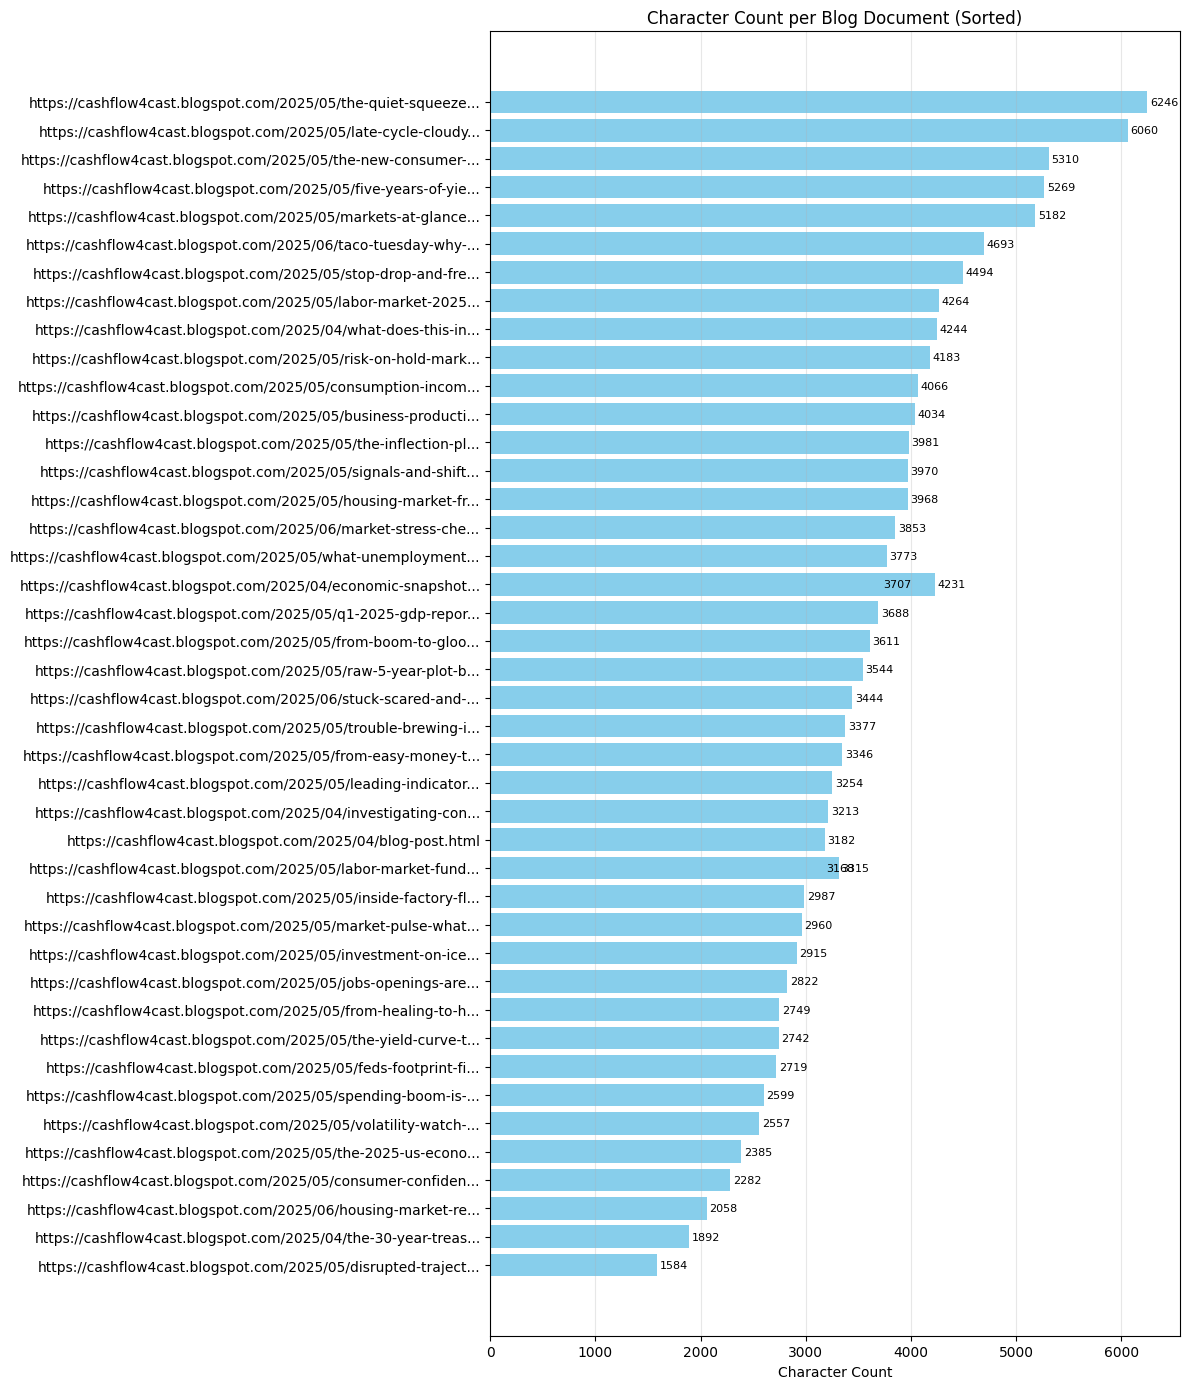

Total documents: 44
Min characters: 1584
Max characters: 6246
Average characters: 3589
                 0
count    44.000000
mean   3589.113636
std    1027.489200
min    1584.000000
25%    2891.750000
50%    3494.000000
75%    4095.250000
max    6246.000000


In [33]:
import matplotlib.pyplot as plt

# ✅ Step 1: Measure character lengths
doc_char_lengths = [len(doc.page_content) for doc in cleaned_documents]
doc_names = [doc.metadata.get("source", f"Doc {i+1}") for i, doc in enumerate(cleaned_documents)]

# ✅ Step 2: Shorten long labels for readability
short_names = [name[:60] + "..." if len(name) > 60 else name for name in doc_names]

# ✅ Step 3: Sort by length
sorted_docs = sorted(zip(short_names, doc_char_lengths), key=lambda x: x[1])
sorted_names, sorted_lengths = zip(*sorted_docs)

# ✅ Step 4: Plot with annotated values
plt.figure(figsize=(12, 14))
bars = plt.barh(sorted_names, sorted_lengths, color='skyblue')
plt.xlabel("Character Count")
plt.title("Character Count per Blog Document (Sorted)")
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)

# ➕ Add value labels next to bars
for bar, length in zip(bars, sorted_lengths):
    plt.text(length + 25, bar.get_y() + bar.get_height()/2, str(length), va='center', fontsize=8)

plt.show()

# ✅ Step 5: Print summary stats
print(f"Total documents: {len(doc_char_lengths)}")
print(f"Min characters: {min(doc_char_lengths)}")
print(f"Max characters: {max(doc_char_lengths)}")
print(f"Average characters: {sum(doc_char_lengths) // len(doc_char_lengths)}")

# import pandas as pd
# print(pd.DataFrame(sorted_lengths).describe())


## Set Params & Chunk


In [35]:
from langchain_openai.chat_models.base import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter

# SET MODEL PARAMS
EMBED_MODEL = "all-MiniLM-L6-v2"
CHUNK_SIZE = 250
CHUNK_OVERLAP = 50
K = 4

# Load token from .env.
load_dotenv("/content/API_KEYS.env", override=True)

LLM_MODEL = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # or "gpt-4-turbo" if budget allows
    temperature=0.3,  # factual, deterministic
    max_tokens=500  # adjust based on response length
)


# 🧩 Chunk using RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

chunked_documents = splitter.split_documents(cleaned_documents)

# 📊 Debug: Average chunk size
avg_length = sum(len(doc.page_content) for doc in chunked_documents) / len(chunked_documents)
print(f"📏 Average chunk length: {avg_length:.1f} characters")

print(f"🧩 Total chunks: {len(chunked_documents)}")

# 🔍 Preview sample chunks
print(f"\nShowing first 5 of {len(chunked_documents)} chunks:\n")
for i, doc in enumerate(chunked_documents[:5]):
    print(f"--- Chunk {i+1} ---")
    print(f"Source: {doc.metadata.get('source', 'N/A')}")
    print(textwrap.fill(doc.page_content[:500], width=100))  # preview first 500 characters
    print("\n")



📏 Average chunk length: 240.7 characters
🧩 Total chunks: 799

Showing first 5 of 799 chunks:

--- Chunk 1 ---
Source: https://cashflow4cast.blogspot.com/2025/06/market-stress-checkup-from-icu-to.html
Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio Cashflow 4Cast Search
Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio on June 10, 2025 Get link
Facebook X Pinterest Email Other Apps Market Stress


--- Chunk 2 ---
Source: https://cashflow4cast.blogspot.com/2025/06/market-stress-checkup-from-icu-to.html
X Pinterest Email Other Apps Market Stress Checkup: From ICU to Outpatient — but Not Cleared for
Cardio Over the past 18 months, the U.S. financial system has endured a series of shocks: aggressive
rate hikes, post-COVID liquidity withdrawal, and


--- Chunk 3 ---
Source: https://cashflow4cast.blogspot.com/2025/06/market-stress-checkup-from-icu-to.html
rate hikes, post-COVID liquidity withdrawal, and most recently, tariff-induced policy u

## Update Cleaning Process

In [39]:
import re
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.chat_models.base import ChatOpenAI
import textwrap

# Set up save path
save_path = "/content/blog_txt_docs"
os.makedirs(save_path, exist_ok=True)

# 1. Load raw documents from blog
loader = WebBaseLoader(blog_urls)
raw_documents = loader.load()

# 2. Clean function
def clean_doc(doc: Document) -> Document:
    text = doc.page_content

    # Remove garbled emoji/unicode sequences
    text = re.sub(r"ü\S{0,10}", "", text)

    # Remove boilerplate UI strings
    for pattern in [
        r"Skip to main content",
        r"Search This Blog",
        r"Get link Facebook X Pinterest Email Other Apps"
    ]:
        text = text.replace(pattern, "")

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return Document(page_content=text, metadata=doc.metadata)

# 3. Clean all docs
cleaned_documents = [clean_doc(doc) for doc in raw_documents]

# 4. Save to individual .txt files
for i, doc in enumerate(cleaned_documents):
    filename = f"blog_{i+1:02}.txt"
    with open(os.path.join(save_path, filename), "w", encoding="utf-8") as f:
        f.write(doc.page_content)

print(f"✅ Saved {len(cleaned_documents)} cleaned blog posts to: {save_path}")

# 5. Preview cleaned content
for i, doc in enumerate(cleaned_documents[:3], 1):
    print(f"\n📄 Cleaned doc {i}:\n" + "-"*40)
    print(doc.page_content[:1000] + "...")

# ✅ Model setup
EMBED_MODEL = "all-MiniLM-L6-v2"
CHUNK_SIZE = 250
CHUNK_OVERLAP = 50
K = 4

load_dotenv("/content/API_KEYS.env", override=True)

LLM_MODEL = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0.3,
    max_tokens=500
)

# 6. Split into chunks
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)
chunked_documents = splitter.split_documents(cleaned_documents)

# 7. Diagnostics
avg_length = sum(len(doc.page_content) for doc in chunked_documents) / len(chunked_documents)
print(f"📏 Average chunk length: {avg_length:.1f} characters")
print(f"🧩 Total chunks: {len(chunked_documents)}")

for i, doc in enumerate(chunked_documents[:5]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Source: {doc.metadata.get('source', 'N/A')}")
    print(textwrap.fill(doc.page_content[:500], width=100))


✅ Saved 44 cleaned blog posts to: /content/blog_txt_docs

📄 Cleaned doc 1:
----------------------------------------
Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio Cashflow 4Cast Search Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio on June 10, 2025 Get link Facebook X Pinterest Email Other Apps Market Stress Checkup: From ICU to Outpatient — but Not Cleared for Cardio Over the past 18 months, the U.S. financial system has endured a series of shocks: aggressive rate hikes, post-COVID liquidity withdrawal, and most recently, tariff-induced policy uncertainty. But as we scan the market's vital signs across interest rates, credit spreads, liquidity, and volatility, a clear narrative emerges: The patient had a heart attack, survived, and is breathing normally again. Let’s walk through what the latest data says — across the 5-year, 1-year, and 180-day views — about the health of the market. The 5-Year Picture: From Overstimulated to Ove



## 🔍 Why We're Switching to `.txt` Files for Document Processing

### ❌ Problem: Web-Scraped Content Is Noisy

When loading blog content using `WebBaseLoader` and cleaning it with regex, we still encounter multiple quality issues:

* **Residual UI elements** like *"Get link Facebook X Pinterest Email Other Apps"* continue to show up.
* **Title repetition** appears at the start of many chunks (e.g., post titles repeated several times).
* **Formatting artifacts** such as garbled emoji encodings (`ü©∫`) and layout clutter remain even after regex filtering.
* **Inconsistent structure**: Since blog pages include headers, footers, search bars, social links, and non-article elements, it's difficult to reliably isolate pure article content.

These artifacts **pollute the embeddings** and **confuse the LLM**, leading to:

* Reduced retrieval precision (irrelevant or repetitive chunks).
* Lower factual grounding (model answers based on UI garbage instead of content).
* Wasted token space in prompts and reranker steps.

---

### ✅ Recommended: Use Cleaned `.txt` Files Instead

By exporting blog post content manually (or in the future, with a clean HTML-to-text pipeline), we gain:

* ✅ **Complete control** over what gets included.
* ✅ **Guaranteed content quality** (no sidebar, header, or social elements).
* ✅ **Cleaner vector embeddings**, improving RAG relevance and clarity.
* ✅ **Consistent document format** for chunking, reranking, and citation.

In practice, this approach has already shown **more coherent chunking**, more faithful query answers, and less model confusion during RAG workflows.

---

### 📦 Next Step

We’ll proceed with:

* Saving each cleaned blog post to a `.txt` file.
* Loading those directly for chunking and embedding.
* Maintaining file metadata for source attribution in RAG outputs.

Let me know if you'd like me to help convert the `.txt` files to chunks next.
